# The 10-armed Testbed

In this section we numerically compare the greedy and $\epsilon$-greedy action-value methods to compare the relative effectiveness of them. We have a set of 2000 randomly generated $k$-armed bandit problems with $k=10$. For each bandit problem, the action values, $q_*(a)$, $a=1,\cdots,10$, were selected according to a standard normal distribution. Then, when a learning method applied to that problem selected action $A_t$ at time step $t$, the actual reward $R_t$, was selected from a normal distribution with mean $q_*(A_t)$ and variance 1. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_episodes = 2000
n_timesteps = 1000
k = 10
epsilons = [0, 0.1, 0.01]
n_epsilons = len(epsilons)

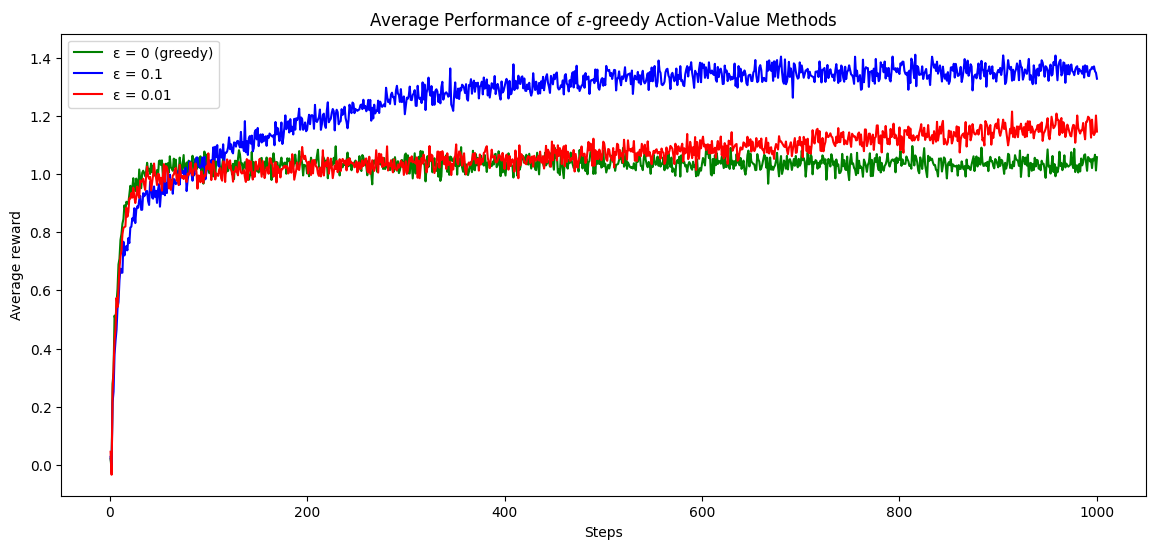

CPU times: user 7min 37s, sys: 9.67 s, total: 7min 47s
Wall time: 7min 47s


In [3]:
%%time

"""
This cell is only to show how computationally inefficient the method from the previous section is.
Only check the output and move to the next part.
"""

history = [[[0 for _ in range(n_timesteps)] for _ in range(n_episodes)] for _ in range(n_epsilons)]

for episode in range(n_episodes):
    q_star = [np.random.normal(0, 1) for _ in range(k)]
    q_hat = [[0 for _ in range(k)] for _ in range(n_epsilons)]
    action_chosen = [[0 for _ in range(n_timesteps)] for _ in range(n_epsilons)]
    
    for timestep in range(n_timesteps):
        # random number between 0 and 1
        random_number = np.random.rand()
        
        for i in range(n_epsilons):
            epsilon = epsilons[i]
            
            # choose a random action with probability epsilon
            if random_number < epsilon:
                action = np.random.choice(range(k))
            else:
                action = np.argmax(q_hat[i])

            # the reward is selected from a normal distribution with mean q_star and variance 1
            reward = np.random.normal(q_star[action], 1)
            history[i][episode][timestep] = reward
            
            action_chosen[i][timestep] = action
            
            n = 0 # number of times action taken prior to timestep
            r = 0 # sum of rewards when action taken prior to timestep
            for t in range(timestep):
                if action_chosen[i][t] == action:
                    n += 1
                    r += history[i][episode][t]
            if n:
                q_hat[i][action] = r / n

# Calculate average reward
avg_rewards = np.zeros((n_epsilons, n_timesteps))
for i in range(n_epsilons):
    for t in range(n_timesteps):
        avg_rewards[i, t] = np.mean([history[i][episode][t] for episode in range(n_episodes)])

# Plotting
plt.figure(figsize=(14, 6))
colours = ['green', 'blue', 'red']
labels = ['ε = 0 (greedy)', 'ε = 0.1', 'ε = 0.01']

for i in range(n_epsilons):
    plt.plot(range(1, n_timesteps + 1), avg_rewards[i], color=colours[i], label=labels[i])

plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.title('Average Performance of $\epsilon$-greedy Action-Value Methods')
plt.legend()
plt.show()

The greedy method turned out to show the poorest performance when compared to $\epsilon$-greedy methods. This is because it got stuck at suboptimal choice of actions. The $\epsilon$-greedy methods performed better in the long run because they continued to explore and to improve the cahnces of recognising the optimal aciton. Note that it is also possible to have decaying $\epsilon$ over time.

The advantage of $\epsilon$-greedy over greedy methods depends on the task. Suppose the reward variance had been larger. With noisier rewards it takes more exploration to find the optimal action, and $\epsilon$-greedy methods should fare even better relative to the greedy method. On the other hand, if the reward variances were zero, then the greedy method would know the true value of each action after trying it once, in which case the greedy method might perform the best because it would find the optimal action and then never explore.

However, even if the reward system was deterministic, if the task was stationary and the true values of the actions change over time, it is beneficial to choose $\epsilon$-greedy methods. Indeed, nonstationarity is the case most commonly encountered in reinforcement learning. Most of the reinforcement learning requires a balance between exploitation and exploration.

## Incremental Implementation

So far, we used sample averages of observed rewards to estimate the action values. In this section we focus on improving the computational efficiency of computing such estimates.

Let $R_i$ denote the reward received _after_ the $i$-th selection of action, and let $Q_n$ denote the estimate of its action value after it has been selected $n-1$ times. Then we have

$$
Q_n = \frac{R_1 + R_2 + \cdots + R_{n-1}}{n-1}.
$$

In the previous section, we had to store the records of all the rewards to calculate $Q_n$. Here, we devise incremental formulas for updating averages with small, constant computation required to process each new reward. Given $Q_n$ and the $n$-th reward $R_n$, the new average of all $n$ rewards can be computed by

$$
\begin{align*}
Q_{n+1} 
&= \frac{1}{n} \sum_{i=1}^n R_i
\\
&= \frac{1}{n} \left( R_n + \sum_{i=1}^{n-1} R_i \right)
\\
&= \frac{1}{n} \left( R_n + (n-1) \frac{1}{n-1} \sum_{i=1}^{n-1}R_i \right)
\\
&= \frac{1}{n} \left( R_n + (n-1)Q_n \right)
\\
&= \frac{1}{n} \left( R_n + nQ_n - Q_n \right)
\\
&= Q_n + \frac{1}{n} (R_n - Q_n)
\end{align*}
$$

Now we only need to store $Q_n$ and $n$. Such an update rule can be generalised by the following form:

$$
\text{new estimate} \leftarrow \text{old estimate} + \text{step size}\left( \text{target - old estimate} \right).
$$

The difference between the target and the old estimate is an _error_ in the estimate, which is reduced by taking a step toward the target. In the case above, the target is the $n$-th reward.

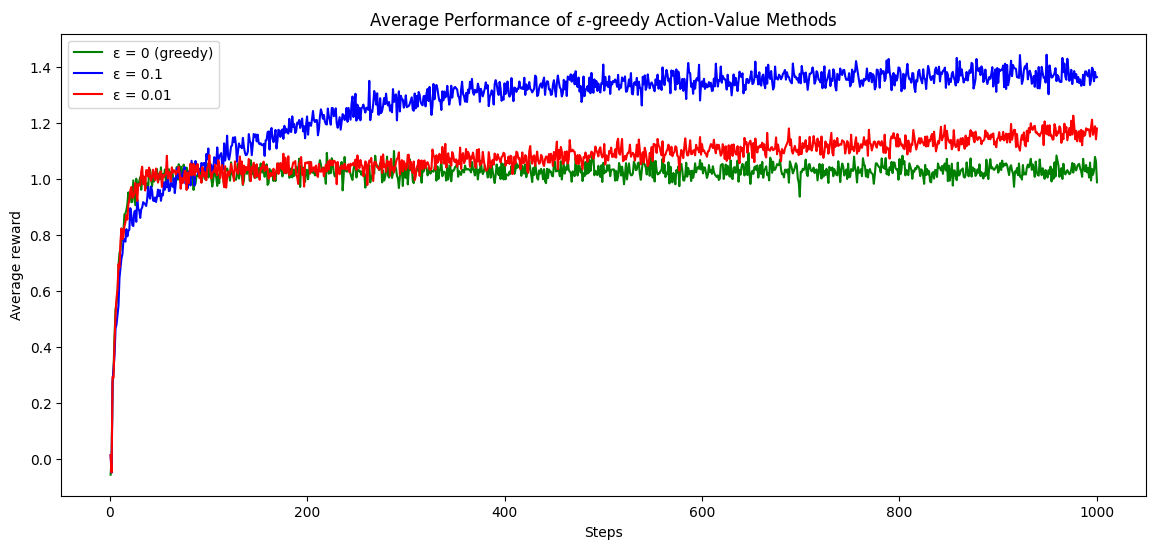

CPU times: user 17.1 s, sys: 361 ms, total: 17.5 s
Wall time: 17.5 s


In [4]:
%%time

"""
Compare the time taken to run to the cell above
"""

history = [[[0 for _ in range(n_timesteps)] for _ in range(n_episodes)] for _ in range(n_epsilons)]

for episode in range(n_episodes):
    q_star = [np.random.normal(0, 1) for _ in range(k)]
    q_hat = [[0 for _ in range(k)] for _ in range(n_epsilons)]
    action_count = [[0 for _ in range(k)] for _ in range(n_epsilons)]
    
    for timestep in range(n_timesteps):
        # random number between 0 and 1
        random_number = np.random.rand()
        
        for i in range(n_epsilons):
            epsilon = epsilons[i]
            
            # choose a random action with probability epsilon
            if random_number < epsilon:
                action = np.random.choice(range(k))
            else:
                action = np.argmax(q_hat[i])

            # the reward is selected from a normal distribution with mean q_star and variance 1
            reward = np.random.normal(q_star[action], 1)
            history[i][episode][timestep] = reward

            # update the estimate of q_star
            if not action_count[i][action]:
                q_hat[i][action] = 0
            else:
                q_hat[i][action] += (reward - q_hat[i][action])/action_count[i][action]

            action_count[i][action] += 1

# Calculate average reward
avg_rewards = np.zeros((n_epsilons, n_timesteps))
for i in range(n_epsilons):
    for t in range(n_timesteps):
        avg_rewards[i, t] = np.mean([history[i][ep][t] for ep in range(n_episodes)])

# Plotting
plt.figure(figsize=(14, 6))
colors = ['green', 'blue', 'red']
labels = ['ε = 0 (greedy)', 'ε = 0.1', 'ε = 0.01']

for i in range(n_epsilons):
    plt.plot(range(1, n_timesteps + 1), avg_rewards[i], color=colors[i], label=labels[i])

plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.title('Average Performance of $\epsilon$-greedy Action-Value Methods')
plt.legend()
plt.show()